<a href="https://colab.research.google.com/github/cliu-15/BE-205-Assn1/blob/main/assn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml 
import cv2
import os
import pandas as pd
from skimage.measure import regionprops, regionprops_table
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

## Pre-Processing/Marker Expression Panel

### Pre-Processing Functions

In [15]:
def normalize_images(data):
    """
    Adaptive histogram normalization by channel, using OpenCV function
    """
    data_normalized = np.zeros(np.shape(data))
    # OpenCV adaptive histogram normalization (CLAHE)
    clahe = cv2.createCLAHE()
    
    for channel in range(np.shape(data)[2]): # channels
        # Adaptive histogram normalization by channel
        img = data[:,:,channel].astype(np.uint8)
        data_normalized[:,:,channel] = clahe.apply(img)
    
    print("Normalization finished")
    return data_normalized

def find_box_size(y):
    """
    Find bounding box dimensions based on whole cell segmentation masks (1)
    """
    whole_cells = y[:,:,1]
    n_cells = np.max(whole_cells)
    
    widths = []
    heights = []

    for i in range(1, n_cells): # skip cell 0 (background)
        # Isolate each whole cell
        cell = (whole_cells[:,:] == i).astype(np.uint8)

        # Extract bounding box for whole cell
        regions = regionprops(cell)
        if len(regions) == 1:
            min_row, min_col, max_row, max_col = regions[0].bbox
            # Calculate width and height of bounding box
            width = max_col - min_col
            height = max_row - min_row

            widths.append(width)
            heights.append(height)

    # Choose average + 1 STD
    w = np.mean(widths) + np.std(widths)
    h = np.mean(heights) + np.std(heights)
    print('Widths: mean ', np.mean(widths), ' + std ', np.std(widths))
    print('Heights: mean ', np.mean(heights), ' + std ', np.std(heights))
    print('Box size: ', w, h)
    
    return w, h   

def extract_marker_expression(X, y, cell_types, w, h):
    """
    Crop cells based on bounding box size and extract marker expression levels    
    """
    # Find cell centroids based on cell nuclei segmentation masks (0)
    nucleus_cells = y[:,:,0]
    n_markers = np.shape(X)[2]
    
    exp_X = []
    exp_y = []
    exp_ids = []

    # Iterate through nuclei
    n_nuclei = np.max(nucleus_cells)

    if cell_types == None:
        r = range(n_nuclei+1)
    else: 
        r = range(1, n_nuclei+1)
    for idx in r: # nuclei segmentation mask id; skip 0 (background)
        # Extract information about cell type
        if cell_types != None:
            exp_y.append(cell_types[idx])
        exp_ids.append(idx)
        
        # Find centroid of nucleus using regionprops
        nucleus_mask = (nucleus_cells == idx).astype(np.uint8)
        y,x = regionprops(nucleus_mask)[0].centroid
        
        # Crop cell
        max_x = np.shape(nucleus_mask)[0]
        max_y = np.shape(nucleus_mask)[1]
        cropped_cell = X[max(math.floor(y-(h/2)),0):min(math.ceil(y+(h/2)),max_y), max(math.floor(x-(w/2)),0):min(math.ceil(x+(w/2)),max_x), :]
        
        # Calculate mean expression for each channel in cropped cell area
        exp_X.append(np.mean(cropped_cell, axis=(0,1)))
    
    return exp_X, exp_y, exp_ids

In [16]:
def preprocess(X, y, cell_types):
    """
    Pre-process and return mean marker expression for given data
    """
    # Reshape data
    X = np.squeeze(X)
    y = np.squeeze(y)
    if cell_types != None:
        cell_types = cell_types.item()

    # Perform adaptive histogram normalization (+save normalized data)
    X = normalize_images(X)

    # Find minimum size of bounding box
    w, h = find_box_size(y)

    # Extract expression data
    exp_X, exp_y, exp_ids = extract_marker_expression(X, y, cell_types, w, h)
    
    return exp_X, exp_y, exp_ids

def preprocess_all(folder):
    """
    Pre-process and save mean marker expressions for all files in folder
    """
    with open(folder+'meta.yaml', 'r') as stream:
        cell_info = yaml.safe_load(stream)
    markers = cell_info['channels']

    df_cols = markers.copy()
    df_cols.extend(['cell_type', 'segmentation_mask_id'])

    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if 'Point' in f and 'expression' not in f:
            print(f)
            data = np.load(f, allow_pickle = True)
            exp_X, exp_y, exp_ids = preprocess(data['X'], data['y'], data['cell_types'])

            # Save as csv
            n_cells = np.shape(exp_y)[0]
            all_data = np.hstack((exp_X, np.reshape(exp_y, (n_cells, 1)), np.reshape(exp_ids, (n_cells,1))))
            df = pd.DataFrame(all_data, columns = df_cols)
            df.to_csv(f.split('.npz')[0]+'_expression.csv', index = False)

In [17]:
def combine_expression_data(folder):
    """
    Combine data from individual CSV files to get overall mean expression
    """
    combined_df = pd.DataFrame()
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if 'expression.csv' in f and 'Point' in f:
            print(f)
            df = pd.read_csv(f)
            combined_df = pd.concat([combined_df, df])

    return combined_df

def plot_heatmap(df, markers, cell_type_names):
    # Group by cell type, take mean
    grouped_df = df.groupby(['cell_type'])[markers].mean()

    # Heatmap for cell expression by cell type
    plt.figure(figsize = (16,5))
    s = sns.heatmap(grouped_df, yticklabels=cell_type_names)
    s.set(xlabel='Marker', ylabel='Cell type', title='Marker Expression Panel')

### Run Pre-Processing + Show Marker Expression Panel

In [ ]:
## Uncomment to run pre-processing on all files in folder
#preprocess_all('/content/gdrive/MyDrive/BE 205/keren/')

/content/gdrive/MyDrive/BE 205/keren/Point10.npz
Normalization finished
Widths: mean  20.4457301550567  + std  8.060628909829342
Heights: mean  21.65771812080537  + std  8.724919622868729
Box size:  28.50635906488604 30.3826377436741
/content/gdrive/MyDrive/BE 205/keren/Point07.npz
Normalization finished
Widths: mean  22.053048065650646  + std  8.819563512832849
Heights: mean  22.27491207502931  + std  9.086243877745538
Box size:  30.872611578483493 31.361155952774848
/content/gdrive/MyDrive/BE 205/keren/Point06.npz
Normalization finished
Widths: mean  21.299863154293533  + std  8.134994075980469
Heights: mean  21.352890865549092  + std  8.159639100714717
Box size:  29.434857230274 29.51252996626381
/content/gdrive/MyDrive/BE 205/keren/Point01.npz
Normalization finished
Widths: mean  19.722401060405225  + std  6.206858908562659
Heights: mean  20.58871425866313  + std  6.5538811946985955
Box size:  25.929259968967884 27.14259545336173
/content/gdrive/MyDrive/BE 205/keren/Point02.npz
Nor

In [6]:
# # Load in cell_info
# folder = '/content/gdrive/MyDrive/BE 205/keren/'

# with open(folder+'/meta.yaml', 'r') as stream:
#     cell_info = yaml.safe_load(stream)
# markers = cell_info['channels']
# cell_types = cell_info['cell_types'].values()

/content/gdrive/MyDrive/BE 205/keren/Point10_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point07_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point06_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point01_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point02_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point08_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point05_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point04_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point09_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point31_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point13_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point22_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point17_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point39_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point14_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Point25_expression.csv
/content/gdrive/MyDrive/BE 205/keren/Poi

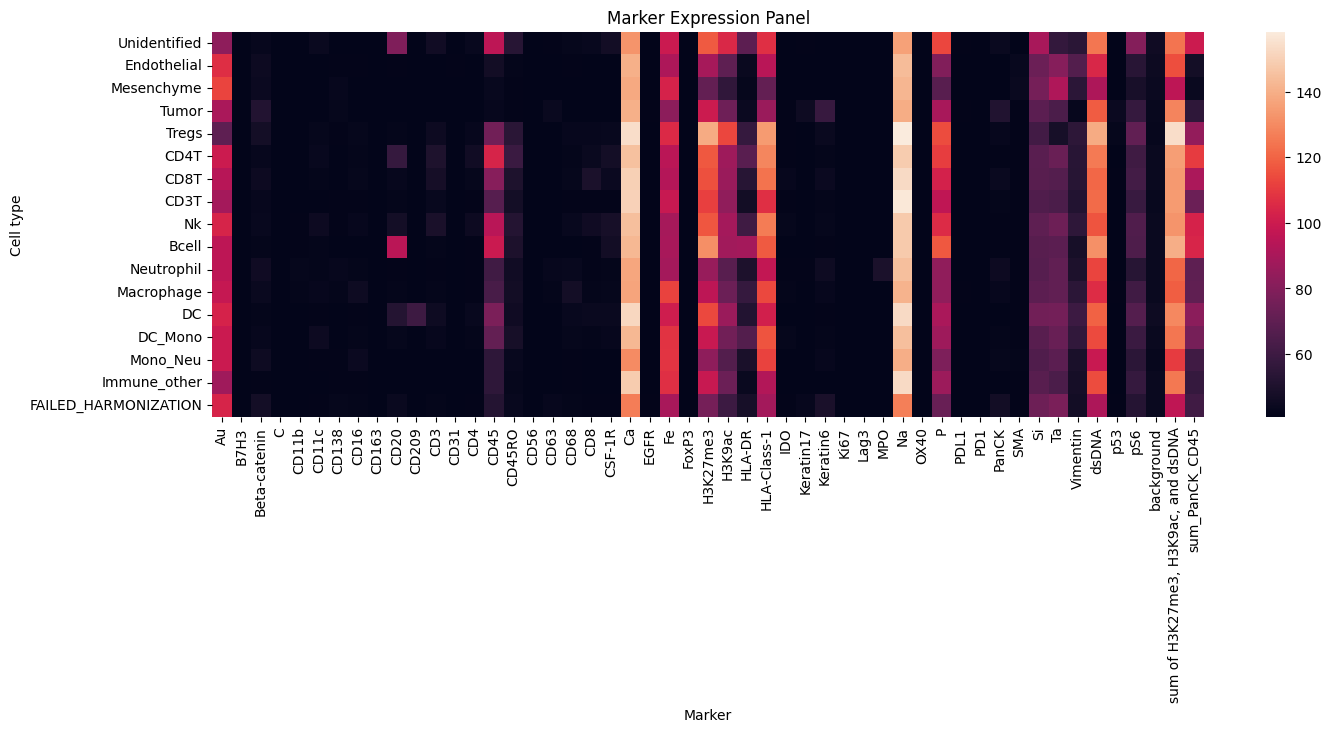

In [7]:
# df = combine_expression_data('/content/gdrive/MyDrive/BE 205/keren/')
# df.to_csv('/content/gdrive/MyDrive/BE 205/keren/combined_expression.csv', index = False)
# plot_heatmap(df, markers, list(cell_types)[1:])

## Select markers (channels) to keep

In [18]:
def select_channels_and_cells(df, all_cells = False):
    """
    Keeps only selected channels and cells. 
    """
    # If no column names header, use indices
    print(df.columns)
    if 'cell_type' not in df.columns:
        cols = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51]
        selected_df = df[cols]
        selected_markers = None
        selected_cell_type_names = None
    else:
        selected_markers = ['B7H3', 'Beta-catenin', 'CD11b', 'CD11c', 'CD138', 
                        'CD16', 'CD163', 'CD20', 'CD209', 'CD3', 'CD31', 'CD4', 'CD45', 
                        'CD45RO', 'CD56', 'CD63', 'CD68', 'CD8', 'CSF-1R', 'EGFR', 
                        'FoxP3', 'H3K27me3', 'H3K9ac', 'HLA-DR', 'HLA-Class-1', 
                        'IDO', 'Keratin17', 'Keratin6', 'Ki67', 'Lag3', 'MPO',  
                        'OX40', 'PDL1', 'PD1', 'PanCK', 'SMA', 'Vimentin', 
                        'dsDNA', 'p53', 'pS6', 'background', 'sum of H3K27me3, H3K9ac, and dsDNA', 
                        'sum_PanCK_CD45']
        cols = selected_markers.copy()
        cols.extend(['cell_type', 'segmentation_mask_id'])
        if all_cells == False:
            selected_cell_types = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
            selected_cell_type_names = ['Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T',
                                    'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 'Immune_other']
            selected_df = df[cols]
        else: 
            selected_cell_types = range(1,18)
            selected_cell_type_names = ['Unidentified', 'Endothelial', 'Mesenchyme', 'Tumor', 
                                        'Tregs', 'CD4T', 'CD8T', 'CD3T', 'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 
                                        'DC', 'DC_Mono', 'Mono_Neu', 'Immune_other', 'FAILED_HARMONIZATION']
            selected_df = df[cols]
        print(selected_cell_type_names)
        selected_df = selected_df.loc[selected_df['cell_type'].isin(selected_cell_types)]

    return selected_df, selected_markers, selected_cell_type_names

Index(['Au', 'B7H3', 'Beta-catenin', 'C', 'CD11b', 'CD11c', 'CD138', 'CD16',
       'CD163', 'CD20', 'CD209', 'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO',
       'CD56', 'CD63', 'CD68', 'CD8', 'CSF-1R', 'Ca', 'EGFR', 'Fe', 'FoxP3',
       'H3K27me3', 'H3K9ac', 'HLA-DR', 'HLA-Class-1', 'IDO', 'Keratin17',
       'Keratin6', 'Ki67', 'Lag3', 'MPO', 'Na', 'OX40', 'P', 'PDL1', 'PD1',
       'PanCK', 'SMA', 'Si', 'Ta', 'Vimentin', 'dsDNA', 'p53', 'pS6',
       'background', 'sum of H3K27me3, H3K9ac, and dsDNA', 'sum_PanCK_CD45',
       'cell_type', 'segmentation_mask_id'],
      dtype='object')
['Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T', 'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 'Immune_other']


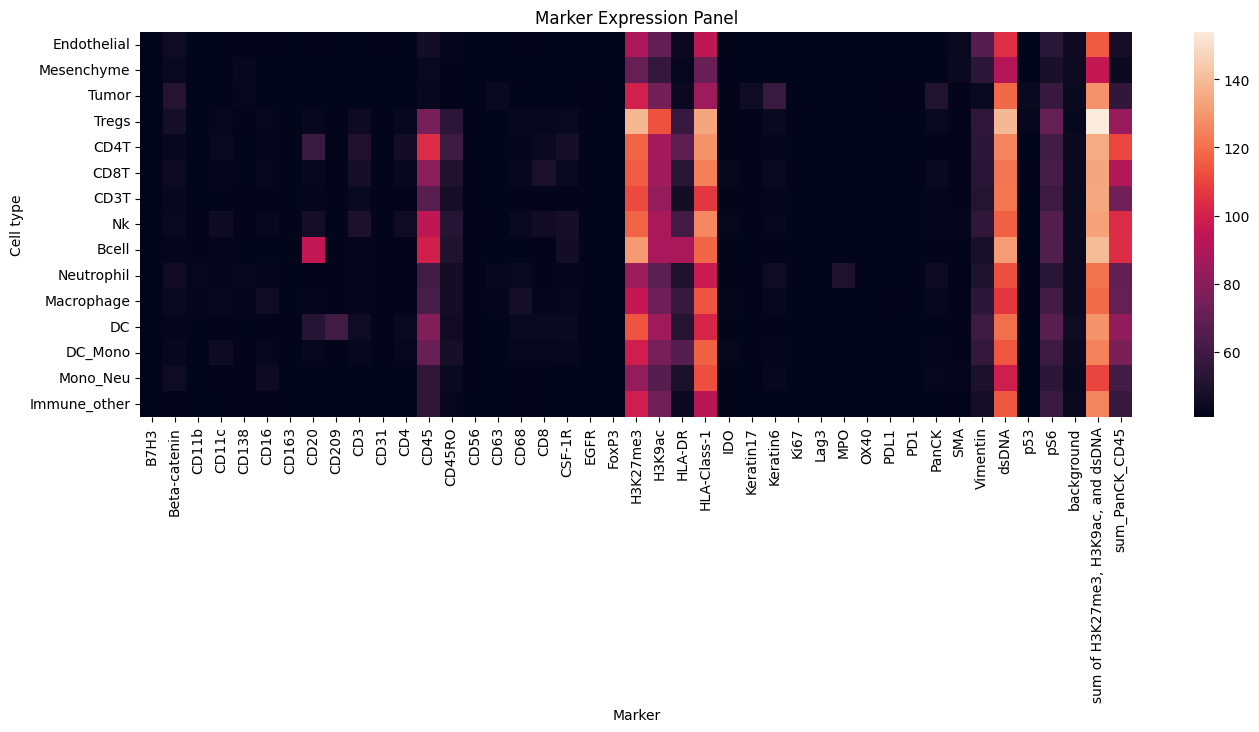

In [9]:
# # Selected markers and cell types
# df = pd.read_csv('/content/gdrive/MyDrive/BE 205/keren/combined_expression.csv')
# selected_df, selected_markers, selected_cell_type_names = select_channels_and_cells(df, all_cells = False)
# selected_df.to_csv('/content/gdrive/MyDrive/BE 205/keren/combined_selected_expression.csv', index = False)
# plot_heatmap(selected_df, selected_markers, selected_cell_type_names)

Index(['Au', 'B7H3', 'Beta-catenin', 'C', 'CD11b', 'CD11c', 'CD138', 'CD16',
       'CD163', 'CD20', 'CD209', 'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO',
       'CD56', 'CD63', 'CD68', 'CD8', 'CSF-1R', 'Ca', 'EGFR', 'Fe', 'FoxP3',
       'H3K27me3', 'H3K9ac', 'HLA-DR', 'HLA-Class-1', 'IDO', 'Keratin17',
       'Keratin6', 'Ki67', 'Lag3', 'MPO', 'Na', 'OX40', 'P', 'PDL1', 'PD1',
       'PanCK', 'SMA', 'Si', 'Ta', 'Vimentin', 'dsDNA', 'p53', 'pS6',
       'background', 'sum of H3K27me3, H3K9ac, and dsDNA', 'sum_PanCK_CD45',
       'cell_type', 'segmentation_mask_id'],
      dtype='object')
['Unidentified', 'Endothelial', 'Mesenchyme', 'Tumor', 'Tregs', 'CD4T', 'CD8T', 'CD3T', 'Nk', 'Bcell', 'Neutrophil', 'Macrophage', 'DC', 'DC_Mono', 'Mono_Neu', 'Immune_other', 'FAILED_HARMONIZATION']


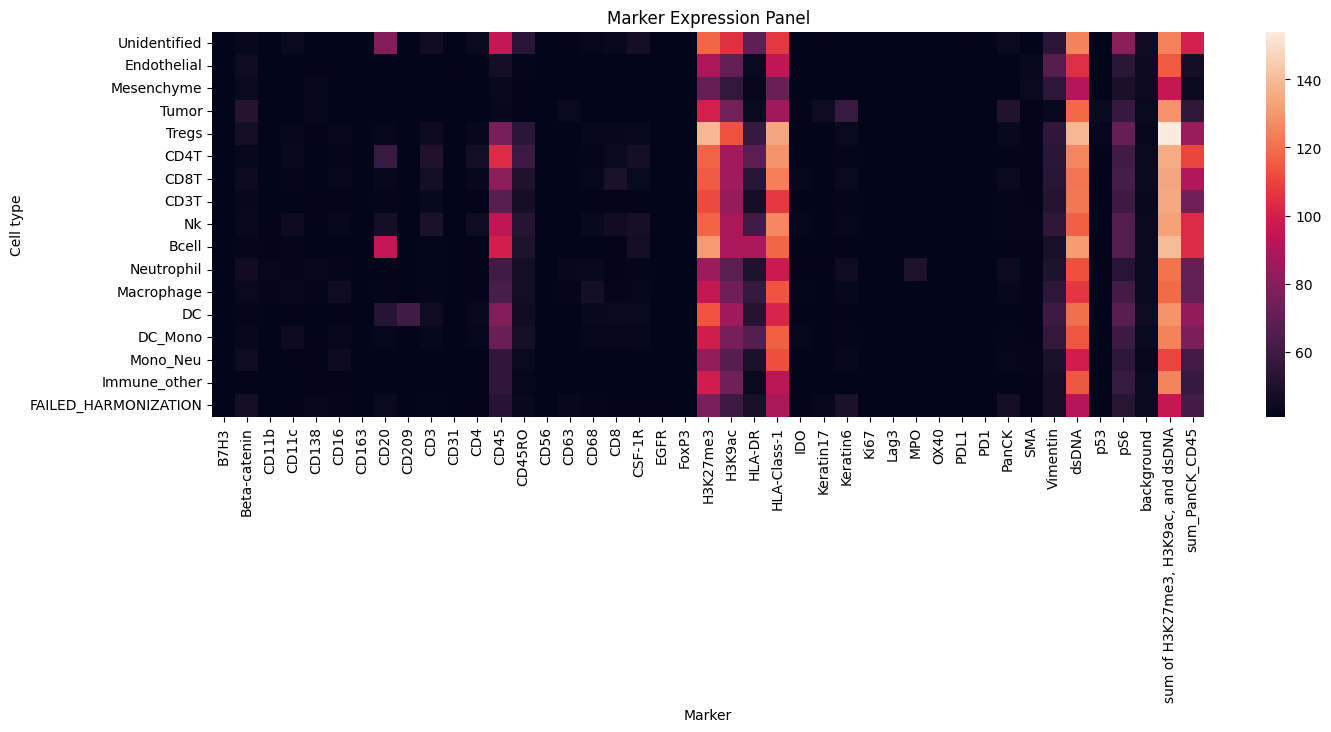

In [10]:
# # Selected markers only (all cell types included)
# df = pd.read_csv('/content/gdrive/MyDrive/BE 205/keren/combined_expression.csv')
# selected_df, selected_markers, selected_cell_type_names = select_channels_and_cells(df, all_cells = True)
# selected_df.to_csv('/content/gdrive/MyDrive/BE 205/keren/combined_selected_expression_all_cells.csv', index = False)
# plot_heatmap(selected_df, selected_markers, selected_cell_type_names)

## Machine Learning Model

In [19]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
class LinearClassifier(torch.nn.Module):
    """
    Simple linear classifier model
    """
    def __init__(self):
        super().__init__()
        #self.output = nn.Linear(43, 15) # for selected cell types only
        self.output = nn.Linear(43, 17) # for all cell types
 
    def forward(self, x):
        x = self.output(x)
        return x

def load_data(filepath):
    """
    Loads in data from .csv dataframe file and creates training and test data
    """
    df = pd.read_csv(filepath)
    n_cols = len(df.columns)

    # Convert to X and y (one-hot encoded)
    X = df.iloc[:,0:n_cols-2]
    y = df.iloc[:,n_cols-2:n_cols-1]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    ids = df.iloc[:,n_cols-1:]

    # Convert to tensors
    X = torch.tensor(X.values, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Split into train/test data
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, shuffle=True)

    # Make dataset and dataloader for training data
    train_dataset = TensorDataset(train_X, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle = True)

    return train_loader, test_X, test_y

def train_model(train_loader, model, lr, optimizer, loss_fn, num_epochs):
    """
    Trains model using training dataset and returns trained model
    """
    model.train()

    train_losses = np.zeros(num_epochs)
    train_accuracies = np.zeros(num_epochs)
    N_train = len(train_loader.dataset)

    for epoch in range(num_epochs):
          total_correct = 0
          train_loss = 0

          for batch_idx, (data, target) in enumerate(train_loader):
              # Erase accumulated gradients
              optimizer.zero_grad()

              # Forward pass
              output = model(data)

              # Calculate loss/accuracy
              loss = loss_fn(output, target)
              train_loss += loss.item()

              pred = output
              total_correct += (1*(torch.argmax(pred, 1) == torch.argmax(target, 1))).sum().item()
            
              # Backward pass
              loss.backward()
              
              # Weight update
              optimizer.step()

          train_loss /= N_train
          train_accuracy = total_correct / N_train

          # Track loss each epoch
          print('Train Epoch: %d  Loss: %.4f  Accuracy %.4f' % (epoch + 1,  
                  train_loss, 
                  train_accuracy))

          # Save to arrays
          train_losses[epoch] = train_loss
          train_accuracies[epoch] = train_accuracy

    return model, train_losses, train_accuracies

def test_model(test_X, test_y, model):
    """
    Tests trained model on holdout set
    """
    model.eval()
    pred = model(test_X)
    pred = torch.argmax(pred,1)
    y = torch.argmax(test_y,1)
    accuracy = (1*(pred == y)).float().mean()
    print('Test accuracy: %.4f' % accuracy)

    return pred, y, accuracy

In [21]:
def train_test_model(filepath, model_name):
    """
    Trains and tests the linear classifier model using a combined dataframe .csv file
    """
    # Set-up data and model
    train_loader, test_X, test_y, = load_data(filepath)
    model = LinearClassifier()
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss()

    # Train and test model
    model, train_losses, train_accuracies = train_model(train_loader, model, lr, optimizer, loss_fn, 20)
    test_pred, test_y, test_accuracy = test_model(test_X, test_y, model)

    torch.save(model, '/content/gdrive/MyDrive/BE 205/keren/'+model_name+'.pt')

    # Plot training losses / accuracies
    plt.plot(train_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(train_accuracies)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    # Confusion matrix
    conf_matrix = confusion_matrix(test_y, test_pred)
    normalized_conf_matrix = [] 
    for i in range(len(conf_matrix)):
        normalized_conf_matrix.append(conf_matrix[i] / np.sum(conf_matrix[i]))

    sns.set(font_scale=0.5)
    s = sns.heatmap(normalized_conf_matrix, cmap='Blues', annot = True, fmt=".2f",
                yticklabels = selected_cell_type_names, xticklabels = selected_cell_type_names)
    s.set(xlabel='Predicted', ylabel = 'True')

Train Epoch: 1  Loss: 0.0102  Accuracy 0.2562
Train Epoch: 2  Loss: 0.0030  Accuracy 0.4534
Train Epoch: 3  Loss: 0.0019  Accuracy 0.5669
Train Epoch: 4  Loss: 0.0015  Accuracy 0.6234
Train Epoch: 5  Loss: 0.0013  Accuracy 0.6549
Train Epoch: 6  Loss: 0.0012  Accuracy 0.6744
Train Epoch: 7  Loss: 0.0011  Accuracy 0.6888
Train Epoch: 8  Loss: 0.0011  Accuracy 0.7002
Train Epoch: 9  Loss: 0.0010  Accuracy 0.7082
Train Epoch: 10  Loss: 0.0010  Accuracy 0.7145
Train Epoch: 11  Loss: 0.0010  Accuracy 0.7203
Train Epoch: 12  Loss: 0.0009  Accuracy 0.7242
Train Epoch: 13  Loss: 0.0009  Accuracy 0.7271
Train Epoch: 14  Loss: 0.0009  Accuracy 0.7291
Train Epoch: 15  Loss: 0.0009  Accuracy 0.7338
Train Epoch: 16  Loss: 0.0009  Accuracy 0.7360
Train Epoch: 17  Loss: 0.0009  Accuracy 0.7377
Train Epoch: 18  Loss: 0.0009  Accuracy 0.7394
Train Epoch: 19  Loss: 0.0009  Accuracy 0.7402
Train Epoch: 20  Loss: 0.0008  Accuracy 0.7417
Test accuracy: 0.7278


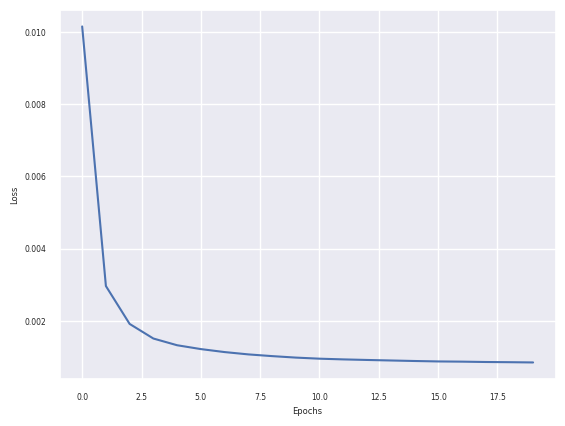

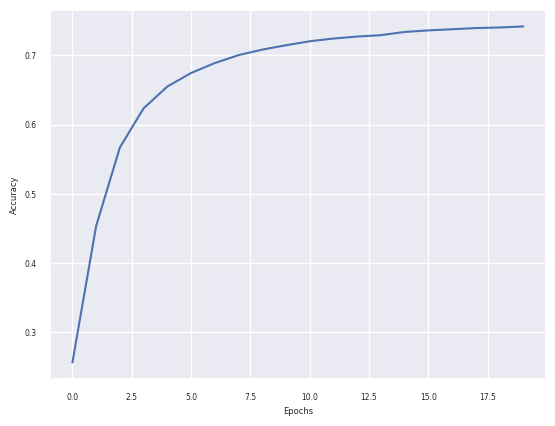

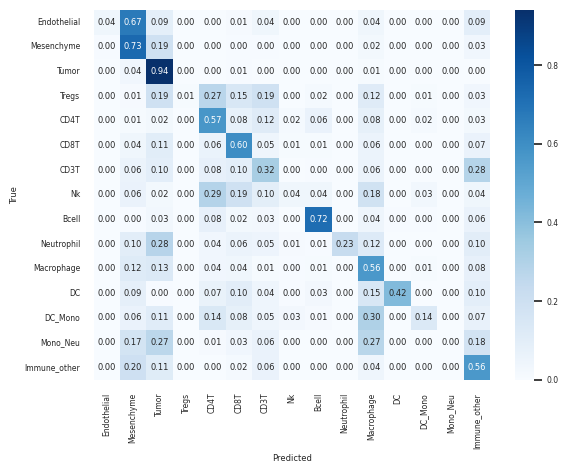

In [13]:
filepath = '/content/gdrive/MyDrive/BE 205/keren/combined_selected_expression.csv'
## Uncomment to train model
#train_test_model(filepath, 'linear_model_selected')

Train Epoch: 1  Loss: 0.0132  Accuracy 0.2262
Train Epoch: 2  Loss: 0.0037  Accuracy 0.3709
Train Epoch: 3  Loss: 0.0024  Accuracy 0.4646
Train Epoch: 4  Loss: 0.0019  Accuracy 0.5182
Train Epoch: 5  Loss: 0.0016  Accuracy 0.5505
Train Epoch: 6  Loss: 0.0015  Accuracy 0.5763
Train Epoch: 7  Loss: 0.0014  Accuracy 0.5941
Train Epoch: 8  Loss: 0.0013  Accuracy 0.6054
Train Epoch: 9  Loss: 0.0013  Accuracy 0.6138
Train Epoch: 10  Loss: 0.0013  Accuracy 0.6213
Train Epoch: 11  Loss: 0.0012  Accuracy 0.6269
Train Epoch: 12  Loss: 0.0012  Accuracy 0.6300
Train Epoch: 13  Loss: 0.0012  Accuracy 0.6341
Train Epoch: 14  Loss: 0.0012  Accuracy 0.6360
Train Epoch: 15  Loss: 0.0012  Accuracy 0.6376
Train Epoch: 16  Loss: 0.0012  Accuracy 0.6392
Train Epoch: 17  Loss: 0.0012  Accuracy 0.6415
Train Epoch: 18  Loss: 0.0012  Accuracy 0.6429
Train Epoch: 19  Loss: 0.0012  Accuracy 0.6431
Train Epoch: 20  Loss: 0.0012  Accuracy 0.6441
Test accuracy: 0.6476


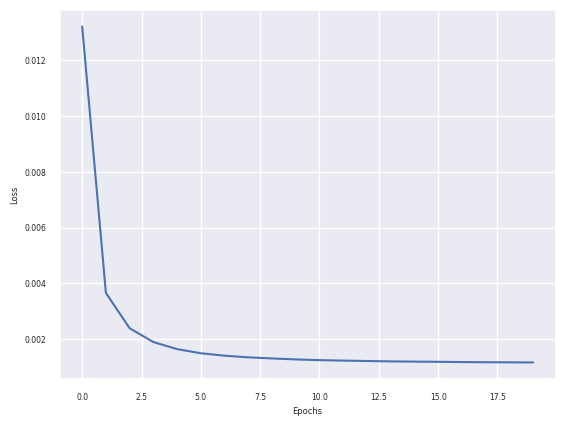

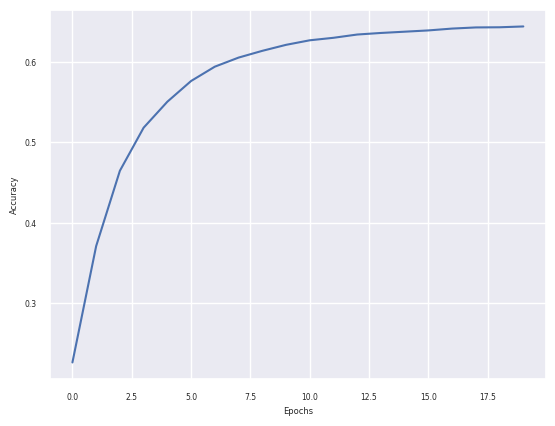

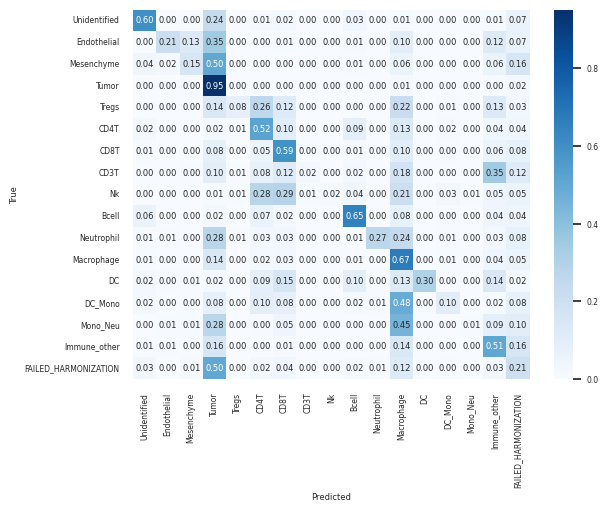

In [76]:
filepath = '/content/gdrive/MyDrive/BE 205/keren/combined_selected_expression_all_cells.csv'
## Uncomment to train model
#train_test_model(filepath, 'linear_model_all')

### Using external data for testing

In [22]:
def test_model_external_selected(X, y, model):
    """
    Takes in X, y, and a trained model and returns a dictionary 
    mapping segmentation mask ids to predicted cell types
    """
    # Pre-processing
    exp_X, _, exp_ids = preprocess(X, y, cell_types=None)

    # Convert to pandas DataFrame
    n_cells = np.shape(exp_ids)[0]
    all_data = np.hstack((exp_X, np.reshape(exp_ids, (n_cells,1))))
    df = pd.DataFrame(all_data)

    # Select markers and cell types of interest
    df, _, _ = select_channels_and_cells(df)

    # Convert to testing X and y
    n_cols = len(df.columns)
    test_X = torch.tensor(df.iloc[:,0:n_cols-1].values, dtype=torch.float32)
    ids = df.iloc[:,n_cols-1:]

    # Test on model
    model.eval()
    pred = model(test_X)
    pred = torch.argmax(pred,1) + 2 # accounting for removed cell types
    pred = pred.detach().numpy()

    # Create dictionary
    pred_dict = dict(zip([int(i) for i in ids[51].tolist()], pred))

    return pred_dict

def test_model_external_all(X, y, model):
    """
    Takes in X, y, and a trained model and returns a dictionary 
    mapping segmentation mask ids to predicted cell types
    """
    # Pre-processing
    exp_X, _, exp_ids = preprocess(X, y, cell_types=None)

    # Convert to pandas DataFrame
    n_cells = np.shape(exp_ids)[0]
    all_data = np.hstack((exp_X, np.reshape(exp_ids, (n_cells,1))))
    df = pd.DataFrame(all_data)

    # Select markers and cell types of interest
    df, _, _ = select_channels_and_cells(df, all_cells = True)

    # Convert to testing X and y
    n_cols = len(df.columns)
    test_X = torch.tensor(df.iloc[:,0:n_cols-1].values, dtype=torch.float32)
    ids = df.iloc[:,n_cols-1:]

    # Test on model
    model.eval()
    pred = model(test_X)
    pred = torch.argmax(pred,1) + 1
    pred = pred.detach().numpy()

    # Create dictionary
    pred_dict = dict(zip([int(i) for i in ids[51].tolist()], pred))

    return pred_dict

Change the filepath here, or set data, X, y, and/or cell_types based on the input data of interest. 
- Note: it should take ~5 min to execute (due to pre-processing time)
- The first cell is using the model trained with only selected cell types (excluding Unknown and FAILED_HARMONIZATION), while the second cell is using the model trained on all cell types



In [23]:
# Selected cell type only trained model

## CHANGE FILEPATH HERE:
filepath = 'Point25.npz'

model = torch.load('linear_model_selected.pt')

data = np.load(filepath, allow_pickle=True)
X = data['X']
y = data['y']
cell_types = data['cell_types'].item()

# Call to the function
pred_dict = test_model_external_selected(X, y, model)


sum = 0
sum_selected = 0
n_selected_cells = 0
for key in pred_dict:
    if cell_types[key] not in [0, 1, 17]: # cell types that were removed from training set
        n_selected_cells += 1
        if pred_dict[key] == cell_types[key]:
            sum_selected += 1
    if pred_dict[key] == cell_types[key]:
        sum += 1
print('Overall accuracy: %.4f' % (sum / len(pred_dict)))
print('Accuracy of selected cell types only: %.4f' % (sum_selected / n_selected_cells))


Normalization finished
Widths: mean  21.29049295774648  + std  8.580149119445549
Heights: mean  20.377200704225352  + std  8.11275455872667
Box size:  29.87064207719203 28.489955262952023
RangeIndex(start=0, stop=52, step=1)
Overall accuracy: 0.6480
Accuracy of selected cell types only: 0.7460


In [24]:
# All cell type trained model

## CHANGE FILEPATH HERE:
filepath = 'Point25.npz'

model = torch.load('linear_model_all.pt')

data = np.load(filepath, allow_pickle=True)
X = data['X']
y = data['y']

cell_types = data['cell_types'].item()

# Call to the function
pred_dict = test_model_external_all(X, y, model)


sum = 0
sum_selected = 0
n_selected_cells = 0
for key in pred_dict:
    if cell_types[key] not in [0, 1, 17]: # cell types that were removed from training set
        n_selected_cells += 1
        if pred_dict[key] == cell_types[key]:
            sum_selected += 1
    if pred_dict[key] == cell_types[key]:
        sum += 1
print('Overall accuracy: %.4f' % (sum / len(pred_dict)))
print('Accuracy of selected cell types only: %.4f' % (sum_selected / n_selected_cells))

Normalization finished
Widths: mean  21.29049295774648  + std  8.580149119445549
Heights: mean  20.377200704225352  + std  8.11275455872667
Box size:  29.87064207719203 28.489955262952023
RangeIndex(start=0, stop=52, step=1)
Overall accuracy: 0.6219
Accuracy of selected cell types only: 0.6920
